confidence no calibration
virtual-labels no calibration


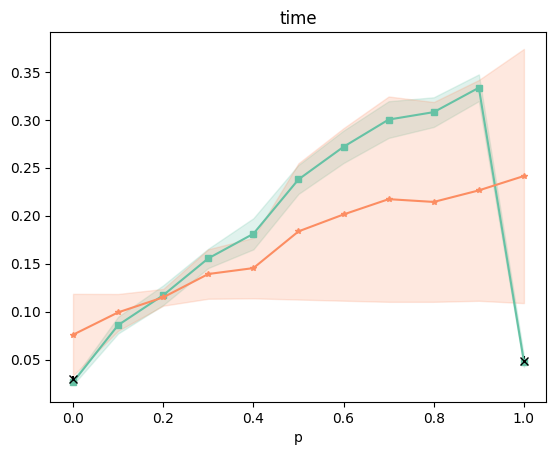

confidence no calibration
virtual-labels no calibration


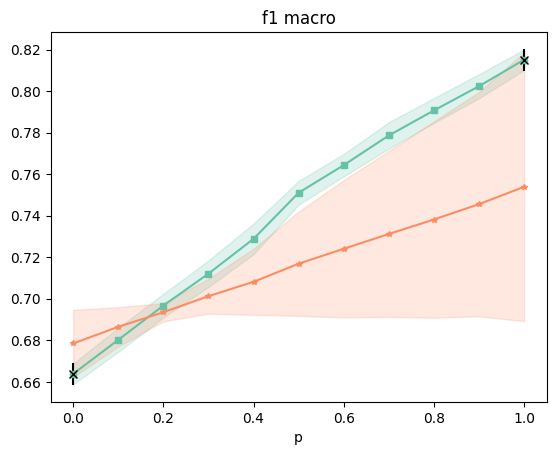

confidence no calibration
virtual-labels no calibration


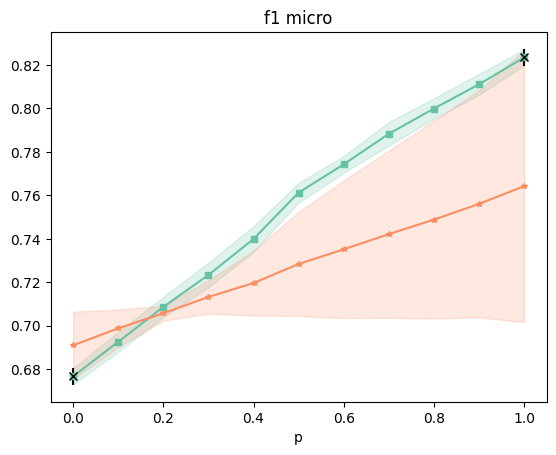

confidence no calibration
virtual-labels no calibration


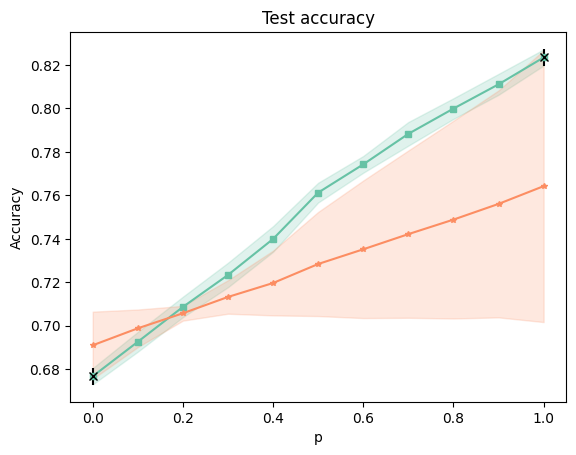

confidence no calibration
virtual-labels no calibration


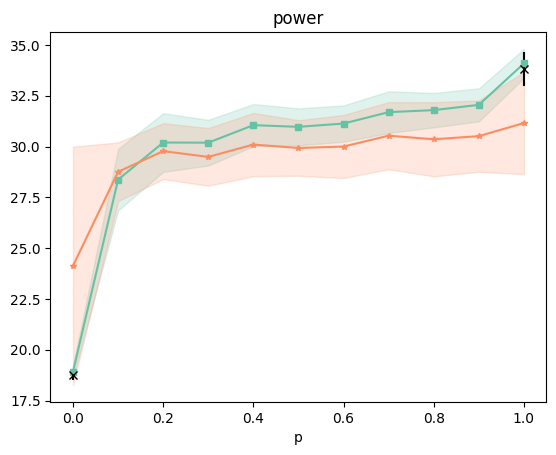

confidence no calibration
virtual-labels no calibration


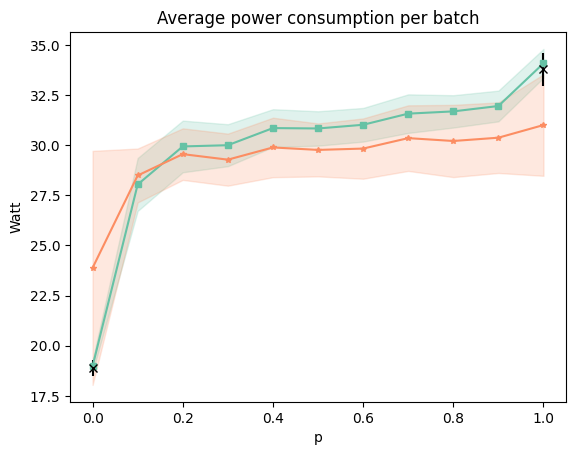

confidence no calibration
virtual-labels no calibration


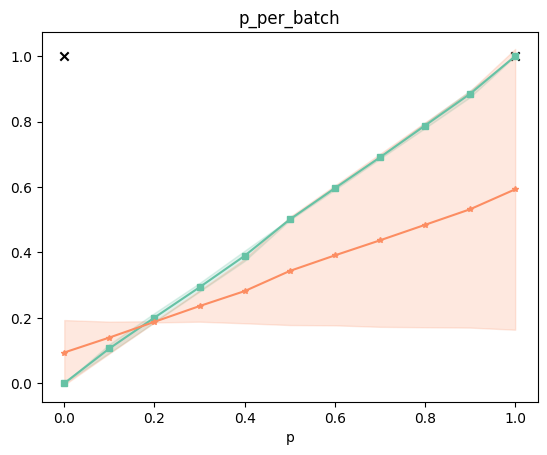

confidence no calibration
virtual-labels no calibration


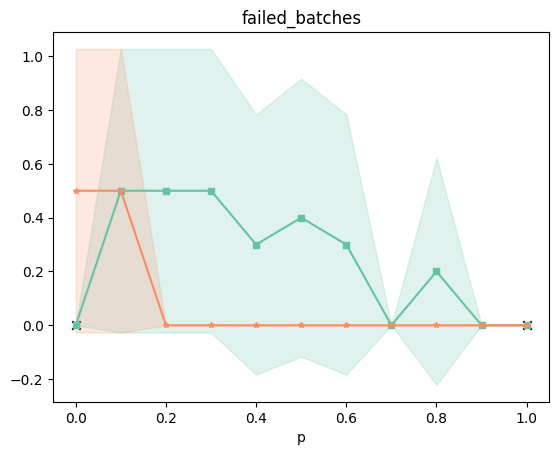

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.patches import PathPatch
from matplotlib.path import Path
plt.rcParams['text.usetex'] = False

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

def plot_key(df, key, markers, colors, ax, show_legend = True):
    ysmall = df[(df["model"] == "small") & (df["batch"] == True)][key]["mean"].values[0]
    ysmall_std = df[(df["model"] == "small") & (df["batch"] == True)][key]["std"].values[0]
    ybig = df[(df["model"] == "big") & (df["batch"] == True)][key]["mean"].values[0]
    ybig_std = df[(df["model"] == "big") & (df["batch"] == True)][key]["std"].values[0]

    if ysmall_std > 0 and ybig_std > 0:
        ax.errorbar([0, 1], [ysmall, ybig], yerr = [ysmall_std, ybig_std], c = "k", fmt='x')
    else:
        ax.scatter([0, 1], [ysmall, ybig], c = "k", marker='x')
    
    plot_number = 0
    legend_entries = []
    for c in df["calibration"].dropna().unique():
        for tm in df["train_method"].dropna().unique():
            print(f"{tm} {'no calibration' if not c else 'calibrated'}")

            x = df[(df["model"] == "RE") & (df["batch"] == True) & (df["train_method"] == tm) & (df["calibration"] == c) ]["p"]
            y = df[(df["model"] == "RE") & (df["batch"] == True) & (df["train_method"] == tm) & (df["calibration"] == c) ][key]["mean"]
            yerr = df[(df["model"] == "RE") & (df["batch"] == True) & (df["train_method"] == tm) & (df["calibration"] == c) ][key]["std"]

            legend_entries.append(f"{tm} {'no calibration' if not c else 'calibrated'}")
            if show_legend:
                ax.plot(x, y , color=colors[plot_number], marker=markers[plot_number], label=f"{tm} {'no calibration' if not c else 'calibrated'}", markersize=4)
            else:
                ax.plot(x, y , color=colors[plot_number], marker=markers[plot_number], markersize=4)

            ax.fill_between(x, y - yerr, y + yerr, color=colors[plot_number], alpha=0.2)
            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0
            # plt.show()
    return legend_entries

def read_json(json_path):
    metrics = json.load(open(json_path,"r"))

    df_metrics = [{
        "model":m["model"],
        "rejector":m["rejector"],
        "run":m["run"],
        "batch":m["batch"],
        "p":m["p"],
        "p_per_batch":m["p_per_batch"],
        "train_method":m["train_method"],
        "calibration":m["calibration"],
        "f1 macro":m["f1 macro"],
        "f1 micro":m["f1 micro"],
        "accuracy":m["accuracy"],
        "time":np.mean(m["time"]),
        "power":np.mean(m["power_per_batch"]),
        "poweravg":np.mean(m["poweravg_per_batch"])
    } for m in metrics]

    df = pd.DataFrame(df_metrics)
    # display(df)
    df["p_per_batch"] = df["p_per_batch"].apply(lambda x: np.mean(x))

    def batch_failed(row):
        p = row["p"]
        return 1 if row["p_per_batch"] > p else 0

    df["failed_batches"] = df.apply(batch_failed, axis=1)
    agg = {
        "time":['mean','std'],
        "f1 macro":['mean','std'],
        "f1 micro":['mean','std'],
        "accuracy":['mean','std'],
        "power":['mean','std'],
        "poweravg":['mean','std'],
        "p_per_batch":['mean','std'],
        "failed_batches":['mean','std'],
    }

    df = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"], dropna=False).agg(agg)
    df.reset_index(inplace=True)
    df["power"] = df["power"] / 1000
    df["poweravg"] = df["poweravg"] / 1000
    return df, agg.keys()

df, agg_keys = read_json("imagenet.json")
# df, agg_keys = read_json("cifar100.json")

display(df)
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
markers = ["s", "*", "x", "D"]

for m in df["rejector"].dropna().unique():
    dff = df[ (df["rejector"] == m) | (df["rejector"].isna()) ]
    for key in agg_keys:
        plot_key(dff, key, markers, colors, plt.gca(), show_legend = True)
        if key == "accuracy":
            plt.title(f"Test accuracy")
            plt.ylabel(f"Accuracy")
        elif key == "poweravg":
            plt.title("Average power consumption per batch")
            plt.ylabel(f"Watt")
        else:    
            plt.title(f"{key}")
        plt.xlabel("p")
        plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


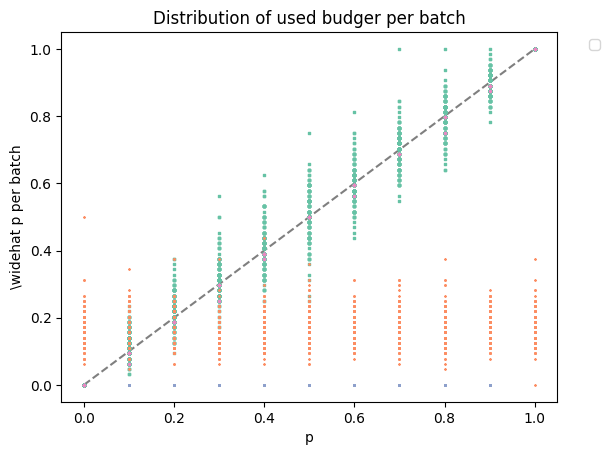

In [2]:
# Define a custom aggregation function to merge lists
def merge_lists(x):
    merged_list = []
    for sublist in x:
        merged_list.extend(sublist)
    return merged_list

def plot_distribution(dff, ax, cal_unique, train_unique, markers, colors):
    ax.plot([0,1],[0,1], c="k", linestyle="--", alpha=0.5, zorder=1)
    plot_number = 0

    for c in cal_unique:
        for tm in train_unique:
            #print(f"RE {tm} {'no calibration' if not c else 'calibrated'}")
            ps = dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) ]["p"]
            for pi in ps:
                y = dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) & (dff["p"] == pi)]["p_per_batch"].values[0]
                x = [pi for _ in range(len(y))]
                ax.scatter(x, y, c = colors[plot_number], marker=markers[plot_number], s=1, zorder=2)
            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0

def read_grouped(json_path):
    metrics = json.load(open(json_path,"r"))

    # Group by specified columns and aggregate
    df = pd.DataFrame(metrics)
    dff = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"]).agg({
        'p_per_batch': merge_lists,
    }).reset_index()

    return dff

dff = read_grouped("cifar100.json")

for rejector in dff["rejector"].dropna().unique():
    plt.xlabel("p")
    plt.ylabel("\widehat p per batch")
    plt.title(f"Distribution of used budger per batch")
    # plt.title(f"Distribution on P with rejector {rejector}")
    plot_distribution(dff, plt.gca(), df["calibration"].dropna().unique(), df["train_method"].dropna().unique(), markers, colors)

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

# tmp = pd.DataFrame(metrics).groupby(["model", "rejector", "p", "batch", "train_method", "calibration"], dropna=False)["p_per_batch"]

# tmp

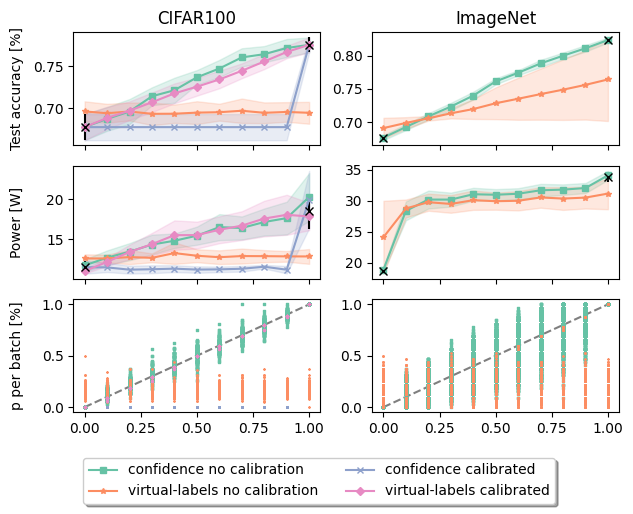

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

fig, axs = plt.subplots(3, 2, sharex=True)
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
markers = ["s", "*", "x", "D"]
for i,jpath in enumerate(["cifar100.json", "imagenet.json"]):
    df,_ = read_json(jpath)
    df_distribution = read_grouped(jpath)

    legend_labels = plot_key(df, "accuracy", markers, colors, axs[0,i], show_legend = i == 0)
    plot_key(df, "power", markers, colors, axs[1,i], show_legend = False)
    plot_distribution(df_distribution, axs[2,i], df["calibration"].dropna().unique(), df["train_method"].dropna().unique(), markers, colors)

    if i == 0:
        axs[0,i].set_ylabel("Test accuracy [%]")
        axs[0,i].yaxis.set_label_coords(-0.2, 0.5)
        axs[1,i].set_ylabel("Power [W]")
        axs[1,i].yaxis.set_label_coords(-0.2, 0.5)
        axs[2,i].set_ylabel("p per batch [%]")
        axs[2,i].yaxis.set_label_coords(-0.2, 0.5)


# Set titles for each column
axs[0, 0].set_title('CIFAR100')
axs[0, 1].set_title('ImageNet')

# Add a legend to the figure
fig.legend(loc='upper center',  bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure to a PDF
with PdfPages('output.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.show()

In [64]:
# Define a custom aggregation function to merge lists
def mean_per_list(x):
    return np.mean(x)

# Group by specified columns and aggregate
df = pd.DataFrame(metrics)
df["p_per_batch"] = df["p_per_batch"].apply(mean_per_list)
dff = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"]).agg({
    "p_per_batch":['mean','std'],
}).reset_index()
display(dff)
asds
for rejector in dff["rejector"].dropna().unique():
    plt.xlabel("p")
    plt.ylabel("p per batch")
    plt.title(f"Distribution on P with rejector {rejector}")
    plt.plot([0,1],[0,1], c="k", linestyle="--")
    plot_number = 0
    for c in df["calibration"].dropna().unique():
        for tm in df["train_method"].dropna().unique():
            print(f"RE {tm} {'no calibration' if not c else 'calibrated'}")
            ps = dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) ]["p"]
            for pi in ps:
                y = dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) & (dff["p"] == pi)]["p_per_batch"].values[0]
                x = [pi for _ in range(len(y))]
                plt.scatter(x, y, c = colors[plot_number], marker='x', s=1.5)
            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()
    asd

model                     rejector     p batch    train_method calibration  \
                                                                                
0     RE  DecisionTreeClassifier_None  0.00  True      confidence       False   
1     RE  DecisionTreeClassifier_None  0.00  True      confidence        True   
2     RE  DecisionTreeClassifier_None  0.00  True  virtual-labels       False   
3     RE  DecisionTreeClassifier_None  0.00  True  virtual-labels        True   
4     RE  DecisionTreeClassifier_None  0.25  True      confidence       False   
5     RE  DecisionTreeClassifier_None  0.25  True      confidence        True   
6     RE  DecisionTreeClassifier_None  0.25  True  virtual-labels       False   
7     RE  DecisionTreeClassifier_None  0.25  True  virtual-labels        True   
8     RE  DecisionTreeClassifier_None  0.50  True      confidence       False   
9     RE  DecisionTreeClassifier_None  0.50  True      confidence        True   
10    RE  DecisionTreeClassifier_None  0.50  True  virtual-labels       False   
11    RE  DecisionTreeClassifier_None  0.50  True  virtual-labels        True   
12    RE  DecisionTreeClassifier_None  0.75  True      confidence       False   
13    RE  DecisionTreeClassifier_None  0.75  True      confidence        True   
14    RE  DecisionTreeClassifier_None  0.75  True  virtual-labels       False   
15    RE  DecisionTreeClassifier_None  0.75  True  virtual-labels        True   
16    RE  DecisionTreeClassifier_None  1.00  True      confidence       False   
17    RE  DecisionTreeClassifier_None  1.00  True      confidence        True   
18    RE  DecisionTreeClassifier_None  1.00  True  virtual-labels       False   
19    RE  DecisionTreeClassifier_None  1.00  True  virtual-labels        True   

   p_per_batch            
          mean       std  
0     0.000000  0.000000  
1     0.000000  0.000000  
2     0.173556  0.013286  
3     0.000000  0.000000  
4     0.272745  0.008112  
5     0.000000  0.000000  
6     0.179292  0.007692  
7     0.250000  0.000000  
8     0.500396  0.006433  
9     0.000000  0.000000  
10    0.175534  0.010209  
11    0.500000  0.000000  
12    0.753362  0.015664  
13    0.000000  0.000000  
14    0.177314  0.013846  
15    0.750000  0.000000  
16    1.000000  0.000000  
17    1.000000  0.000000  
18    0.178402  0.011748  
19    1.000000  0.000000

NameError: name 'asds' is not defined

In [ ]:
for rejector in df["rejector"].dropna().unique():
    plt.xlabel("p")
    plt.ylabel("p per batch")
    plt.title(f"Distribution on P with rejector {rejector}")
    plt.plot([0,1],[0,1], c="k", linestyle="--")
    plot_number = 0
    for m in metrics:
        c = m["calibration"]
        tm = m["train_method"]

        # These scatter plots only make sense in the batch setting
        if m["batch"] and m["run"] == 0:
            y = m["p_per_batch"]
            x = [m["p"] for _ in range(len(m["p_per_batch"]))]
            
            plt.scatter(x, y, c = colors[0], label=f"RE {tm} {'no calibration' if not c else 'calibrated'}", marker='x', s=1.5)
            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()
    asd

# for rejector in df["rejector"].dropna().unique():
#     x_rewoc_batch = []
#     y_rewoc_batch = []
#     x_re_batch = []
#     y_re_batch = []

#     x_rewoc_realtime = []
#     y_rewoc_realtime = []
#     x_re_realtime = []
#     y_re_realtime = []

#     data = []
#     for m in metrics:
#         data.append({
#             "model":m["model"],
#             "run":m["run"],
#             "batch":m["batch"],
#             "rejector":m["rejector"],
#             "p":m["p"],
#             "y": np.mean(m["p_per_batch"]),
#             "y_std":np.std(m["p_per_batch"])
#         })


#     df = pd.DataFrame(data)
#     agg = {
#         "y":['mean'],
#         "y_std":['mean'],
#     }

#     dff = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"], dropna=False).agg(agg)
#     dff.reset_index(inplace=True)

#     # display(dff)
#     re_p_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["p"]
#     re_mean_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["y"]["mean"]
#     re_std_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["y_std"]["mean"]
#     rewoc_p_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["p"]
#     rewoc_mean_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["y"]["mean"]
#     rewoc_std_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["y_std"]["mean"]

#     re_p_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["p"]
#     re_mean_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["y"]["mean"]
#     re_std_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["y_std"]["mean"]
#     rewoc_p_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["p"]
#     rewoc_mean_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["y"]["mean"]
#     rewoc_std_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["y_std"]["mean"]

#     plt.title(f"Distribution of Ps with rejector {rejector}")
#     plt.plot(re_p_batch.values, re_mean_batch.values, color=colors[0], label="RE (batch)")
#     plt.fill_between(re_p_batch, np.maximum(0, re_mean_batch - re_std_batch), np.minimum(1, re_mean_batch + re_std_batch), color=colors[0], alpha=0.2)

#     plt.plot(re_p_realtime, re_mean_realtime , color=colors[2], label="RE (realtime)")
#     plt.fill_between(re_p_realtime, np.maximum(0, re_mean_realtime - re_std_realtime), np.minimum(1, re_mean_realtime + re_std_realtime), color=colors[2], alpha=0.2)

#     plt.plot(rewoc_p_batch, rewoc_mean_batch, color=colors[1], label="REwOC (batch)")
#     plt.fill_between(rewoc_p_batch, np.maximum(0, rewoc_mean_batch - rewoc_std_batch), np.minimum(1, rewoc_mean_batch + rewoc_std_batch), color=colors[1], alpha=0.2)

#     plt.plot(rewoc_p_realtime, rewoc_mean_realtime, color=colors[3], label="REwOC (realtime)")
#     plt.fill_between(rewoc_p_realtime, np.maximum(0, rewoc_mean_realtime - rewoc_std_realtime), np.minimum(1, rewoc_mean_realtime + rewoc_std_realtime), color=colors[3], alpha=0.2)

#     plt.legend(loc='upper left')
#     plt.show()

    # display(df)
    # asd

        # if m["batch"] == b:
        #     if m["rejector"] == rejector and m["model"] == "RE":
        #         if not m["run"] in data:
        #             data[m["run"]] = {
        #             }
        #         else:
        #             if m["p"] not in data[m["run"]]:
        #                 data[m["run"]][m["p"]] = []
        #             tmp = (~(np.array(m["p_per_batch"]) <= m["p"])).astype(int)
        #             data[m["run"]][m["p"]].extend(tmp)
                    #data[m["run"]][m["p"]] = m["p"]
    # for run in data:
    #     for p in data[run]:
    #         data[run][p] = np.mean(data[run][p])
    # x = []
    # y = []
    # yerr = []
    # for p in sorted(data[0].keys()):
    #     x.append(p)
    #     tmp = []
    #     for k in data.keys():
    #         tmp.append(data[k][p])
    #     y.append(np.mean(tmp))
    #     yerr.append(np.std(tmp))
    
    # y = np.array(y)
    # yerr = np.array(yerr)
    # plt.xlabel("p")
    # plt.ylabel("Percentage of failed batches")
    # plt.title(f"Percetange of batches with failed budget and rejector {rejector}")
    # plt.plot(x, y, c = "b")
    # plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.2)
    # plt.show()